
Testing on Cora dataset
Epoch 0, Loss: 1.9554, Accuracy: 0.4290
Epoch 10, Loss: 0.6298, Accuracy: 0.7930
Epoch 20, Loss: 0.1212, Accuracy: 0.7930
Epoch 30, Loss: 0.0318, Accuracy: 0.7930
Epoch 40, Loss: 0.0167, Accuracy: 0.7970
Epoch 50, Loss: 0.0146, Accuracy: 0.7960
Epoch 60, Loss: 0.0160, Accuracy: 0.7960
Epoch 70, Loss: 0.0177, Accuracy: 0.8010
Epoch 80, Loss: 0.0184, Accuracy: 0.7990
Epoch 90, Loss: 0.0178, Accuracy: 0.7980


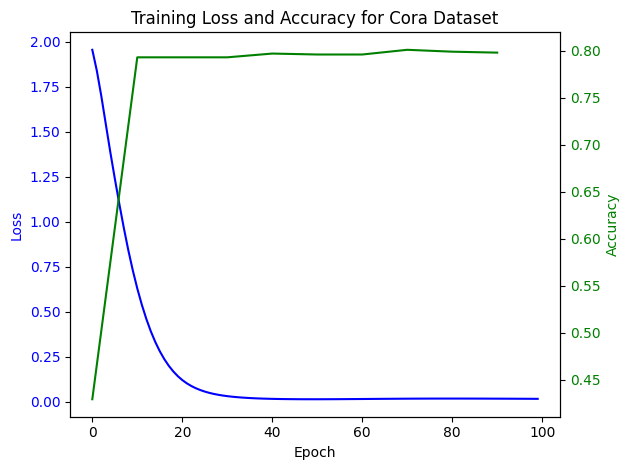

Final Metrics on Cora - Accuracy: 0.8010, Precision: 0.8162, Recall: 0.8010, F1-Score: 0.8025


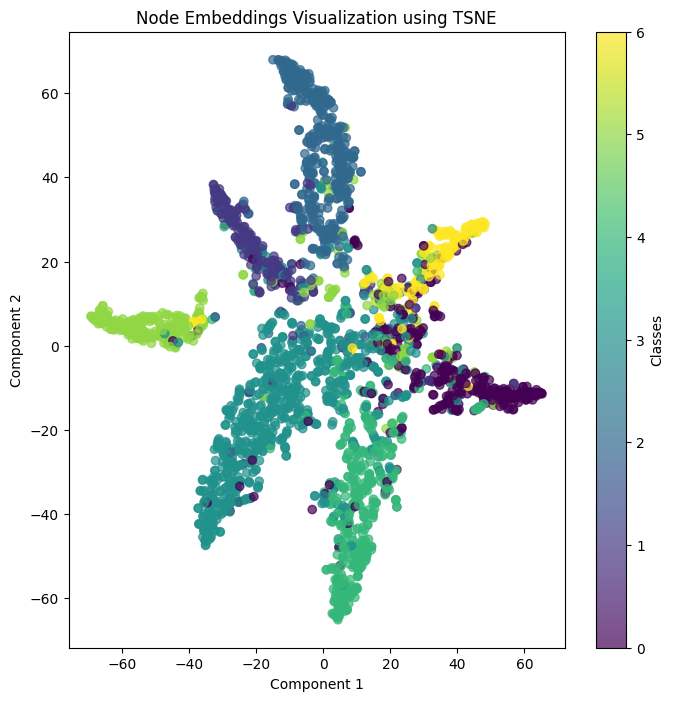

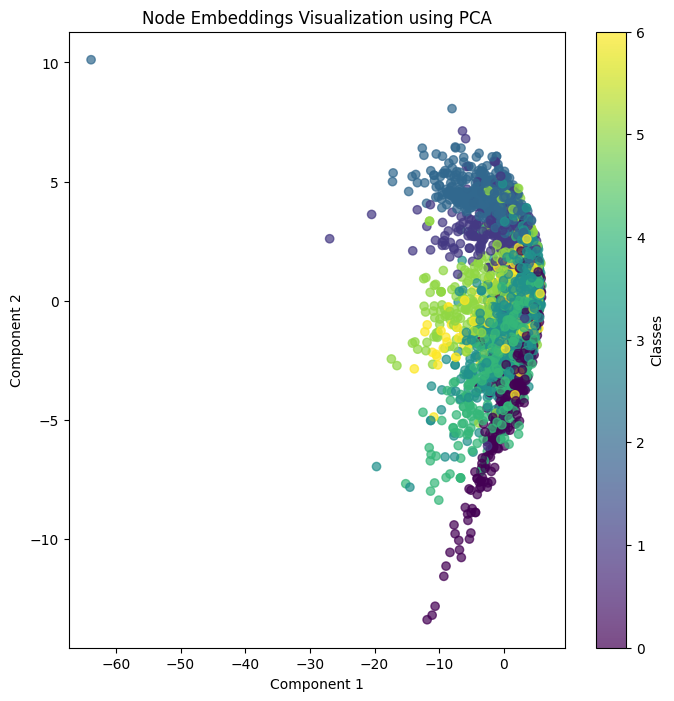


Testing on PubMed dataset


Processing...
Done!


Epoch 0, Loss: 1.0998, Accuracy: 0.4790
Epoch 10, Loss: 0.9299, Accuracy: 0.7430
Epoch 20, Loss: 0.6711, Accuracy: 0.7510
Epoch 30, Loss: 0.4278, Accuracy: 0.7670
Epoch 40, Loss: 0.2641, Accuracy: 0.7710
Epoch 50, Loss: 0.1753, Accuracy: 0.7760
Epoch 60, Loss: 0.1319, Accuracy: 0.7770
Epoch 70, Loss: 0.1107, Accuracy: 0.7810
Epoch 80, Loss: 0.0983, Accuracy: 0.7850
Epoch 90, Loss: 0.0892, Accuracy: 0.7890


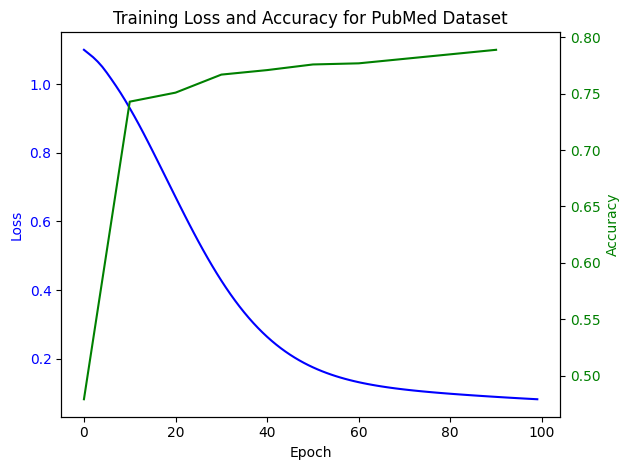

Final Metrics on PubMed - Accuracy: 0.7910, Precision: 0.7946, Recall: 0.7910, F1-Score: 0.7903


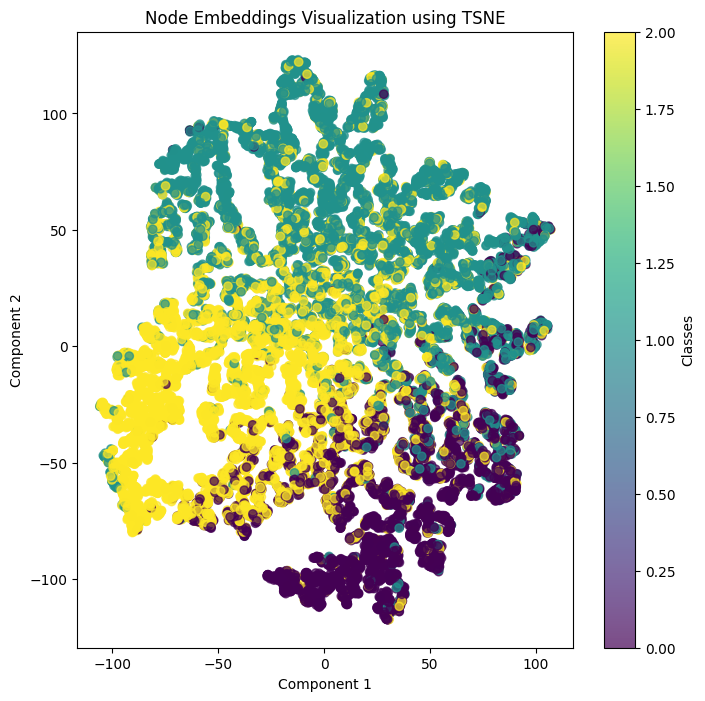

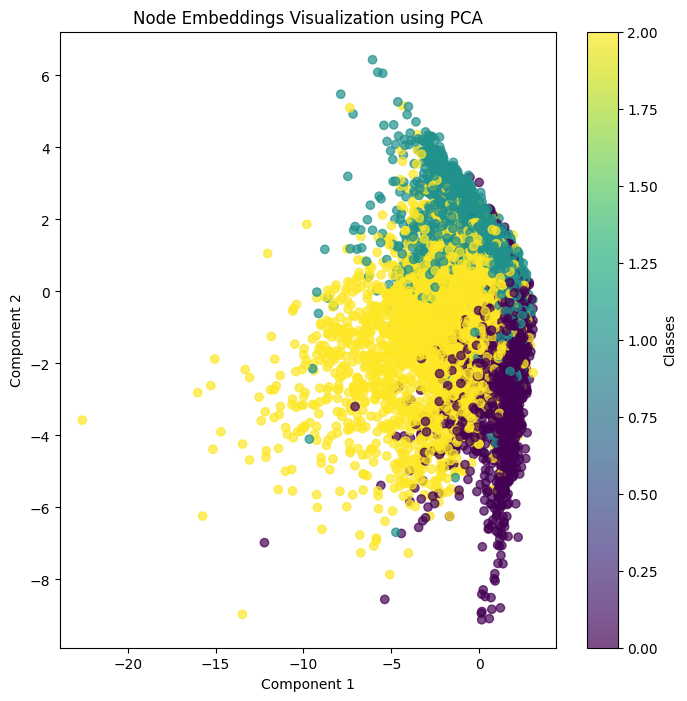


Testing on CiteSeer dataset


Processing...
Done!


Epoch 0, Loss: 1.7953, Accuracy: 0.4540
Epoch 10, Loss: 0.2205, Accuracy: 0.6370
Epoch 20, Loss: 0.0265, Accuracy: 0.6580
Epoch 30, Loss: 0.0090, Accuracy: 0.6600
Epoch 40, Loss: 0.0077, Accuracy: 0.6690
Epoch 50, Loss: 0.0094, Accuracy: 0.6840
Epoch 60, Loss: 0.0115, Accuracy: 0.6850
Epoch 70, Loss: 0.0123, Accuracy: 0.6840
Epoch 80, Loss: 0.0120, Accuracy: 0.6810
Epoch 90, Loss: 0.0114, Accuracy: 0.6830


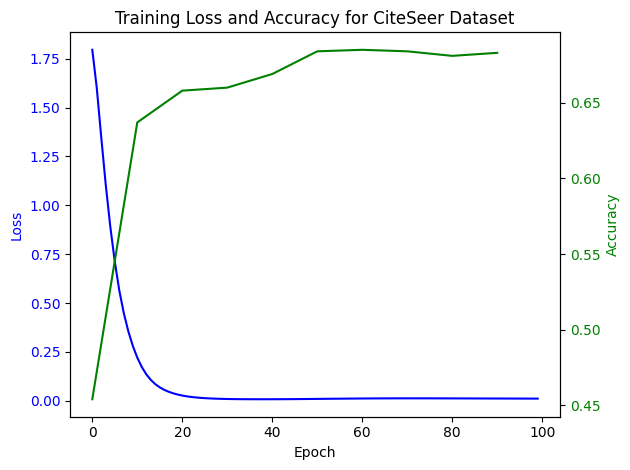

Final Metrics on CiteSeer - Accuracy: 0.6820, Precision: 0.7049, Recall: 0.6820, F1-Score: 0.6889


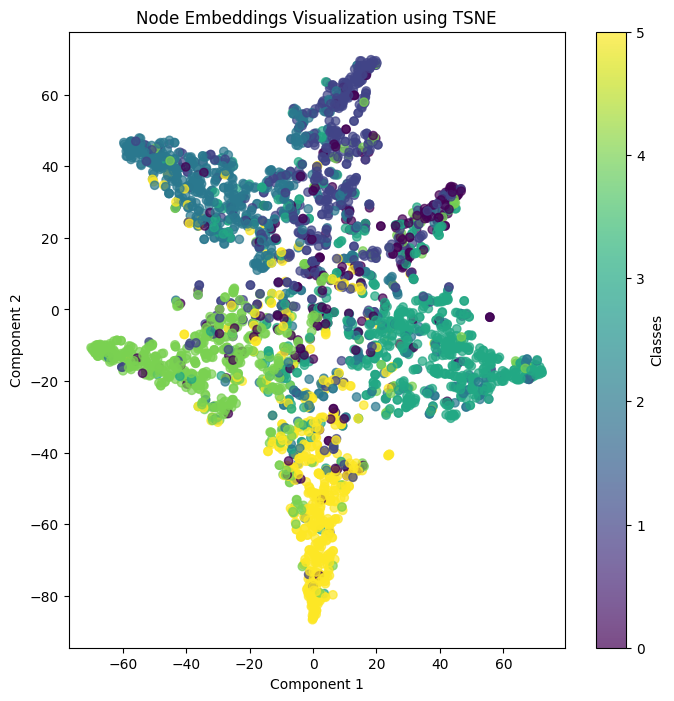

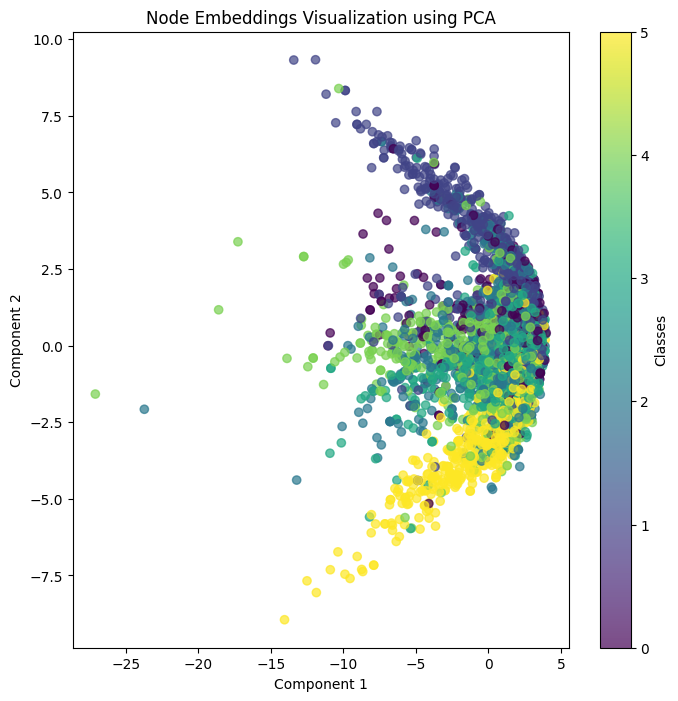

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Defining the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Function to train the model
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Function to evaluate the model
def test(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = accuracy_score(data.y[test_mask].cpu(), pred.cpu())
        prec = precision_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
        rec = recall_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
        f1 = f1_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
    return acc, prec, rec, f1

# Function to visualize node embeddings using t-SNE or PCA
def visualize_embeddings(embeddings, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title(f'Node Embeddings Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Datasets to test
datasets = ['Cora', 'PubMed', 'CiteSeer']

# Hyperparameters
hidden_dim = 16
learning_rate = 0.01
epochs = 100

# Loop through datasets
for dataset_name in datasets:
    print(f"\nTesting on {dataset_name} dataset")
    dataset = Planetoid(root='../data', name=dataset_name)
    data = dataset[0].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Model and optimizer setup
    model = GCN(input_dim=dataset.num_node_features, hidden_dim=hidden_dim, output_dim=dataset.num_classes).to(data.x.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

    # Tracking losses and accuracies
    losses = []
    accuracies = []

    # Training loop
    for epoch in range(epochs):
        loss = train(model, data, optimizer)
        losses.append(loss)

        if epoch % 10 == 0:
            acc, prec, rec, f1 = test(model, data)
            accuracies.append(acc)
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    # Plot training loss and accuracy over epochs for this dataset
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label='Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(range(0, epochs, 10), accuracies, label='Accuracy', color='green')
    ax2.set_ylabel('Accuracy', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title(f"Training Loss and Accuracy for {dataset_name} Dataset")
    fig.tight_layout()
    plt.show()

    # Final evaluation on this dataset
    acc, prec, rec, f1 = test(model, data)
    print(f"Final Metrics on {dataset_name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")

    # Get the final embeddings from the model for visualization
    model.eval()
    with torch.no_grad():
        final_embeddings = model(data).cpu().numpy()

    # Visualize embeddings using t-SNE and PCA
    visualize_embeddings(final_embeddings, data.y.cpu(), method='tsne')
    visualize_embeddings(final_embeddings, data.y.cpu(), method='pca')
